In [1]:
import cv2
import sys, os
import argparse
import numpy as np
import torch
from pathlib import Path
from matplotlib import pyplot as plt
from typing import Any, Dict, List
import pandas as pd

from sam_segment import predict_masks_with_sam
from utils import load_img_to_array, save_array_to_img, dilate_mask, \
    show_mask, show_points, get_clicked_point

/raid/coss07/anaconda3/envs/IA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_folder_path =f'../wim_data/objects/img/'
mask_folder_path = f'../wim_data/objects/mask/'

In [3]:
file_names = [os.path.splitext(f)[0] for f in os.listdir(img_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print(len(file_names))

11860


In [6]:
# 파일 길이 기준
length_threshold = 40

# 길이가 50자 이하인 파일 삭제
for file_name in file_names:
    if len(file_name) <= length_threshold:
        os.remove(os.path.join(img_folder_path, file_name+'.jpg'))

# 삭제 후의 파일 개수 확인
remaining_files = [f for f in os.listdir(img_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print("남은 파일 개수:", len(remaining_files))

남은 파일 개수: 11860


In [4]:
from PIL import Image
import random

# 이미지 폴더 경로 설정
obj_folder_path = '../wim_data/objects/img/'

# 이미지 파일 리스트 가져오기
object_files = [f for f in os.listdir(obj_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print(len(object_files))

11860


In [5]:
import random
# 이미지 및 객체 이미지 경로 설정
base_image_path = '../wim_data/objects/conveyer_resized.jpg'
object_images_folder = '../wim_data/objects/img/'
object_masks_folder = '../wim_data/objects/mask/'
output_folder = '../wim_data/crop_paste/crop_paste_random/'

In [6]:
# YOLO 라벨 형식으로 변환
def convert_to_yolo_label(bbox, img_width, img_height):
    x_center = (bbox[0] + bbox[2]) / 2
    y_center = (bbox[1] + bbox[3]) / 2
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    return x_center/img_width, y_center/img_height, width/img_width, height/img_height

In [21]:

# 기본 이미지 로드
base_image = cv2.imread(base_image_path)
img_height, img_width, _ = base_image.shape

# 지정된 영역 (x 시작, y 시작, 너비, 높이)
rectangle = (300, 0, 680, 740)

# 객체 이미지 목록 가져오기
object_images = os.listdir(object_images_folder)
random.shuffle(object_images) # 랜덤화

# 객체 이미지 배치 및 라벨 생성
labels = []

In [22]:
len(object_images)

11860

In [ ]:
def extract_foreground(obj_img, mask_img):
    # 마스크에서 전경을 추출합니다.
    foreground = cv2.bitwise_and(obj_img, obj_img, mask=mask_img)
    return foreground

In [ ]:
# 두 객체가 겹치는지 확인하는 함수
def check_overlap(obj1, obj2):
    x1, y1, w1, h1 = obj1
    x2, y2, w2, h2 = obj2
    return not (x1 + w1 <= x2 or x1 >= x2 + w2 or y1 + h1 <= y2 or y1 >= y2 + h2)

In [ ]:
# 겹치지 않는 위치 찾기 함수
def find_non_overlapping_position(obj_shape, existing_objects, rectangle):
    max_attempts = 50  # 겹치지 않는 위치를 찾기 위한 최대 시도 횟수
    for _ in range(max_attempts):
        x_offset = random.randint(rectangle[0], rectangle[0] + rectangle[2] - obj_shape[1])
        y_offset = random.randint(rectangle[1], rectangle[1] + rectangle[3] - obj_shape[0])
        new_obj = (x_offset, y_offset, obj_shape[1], obj_shape[0])

        # 기존 객체들과 겹치는지 확인
        if not any(check_overlap(new_obj, obj) for obj in existing_objects):
            return new_obj
    return None  # 겹치지 않는 위치를 찾지 못한 경우

In [23]:
# 이미 배치된 객체들의 위치를 저장할 리스트
placed_objects = []

for obj_img_name in object_images[:7]: # 최소 7개 객체
    parts = obj_img_name.split('_')
    obj_class = parts[2]  # 파일명에서 클래스 추출 (예: '1')
    obj_img_path = os.path.join(object_images_folder, obj_img_name)
    obj_img = cv2.imread(obj_img_path)
    
    obj_shape = obj_img.shape[:2]
    
    
    # 객체 이미지와 마스크 이미지 로드
    _, mask = cv2.threshold(cv2.cvtColor(obj_img, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)
    
    foreground = extract_foreground(obj_img, mask)
    
    position = find_non_overlapping_position(obj_shape, placed_objects, rectangle)
    if position is not None:
        x_offset, y_offset, _, _ = position
        base_image[y_offset:y_offset+obj_shape[0], x_offset:x_offset+obj_shape[1]] = foreground
        placed_objects.append(position)
     
    # 라벨 생성
    bbox = [x_offset, y_offset, x_offset+obj_shape[1], y_offset+obj_shape[0]]
    yolo_label = convert_to_yolo_label(bbox, img_width, img_height)
    labels.append(f"{obj_class} {yolo_label[0]} {yolo_label[1]} {yolo_label[2]} {yolo_label[3]}")


In [24]:
# 결과 이미지 저장
output_image_path = os.path.join(output_folder+'images/', 'test.jpg')
cv2.imwrite(output_image_path, base_image)

# 라벨 파일 저장
with open(os.path.join(output_folder+'labels/', 'test.txt'), 'w') as file:
    for label in labels:
        file.write("%s\n" % label)
        

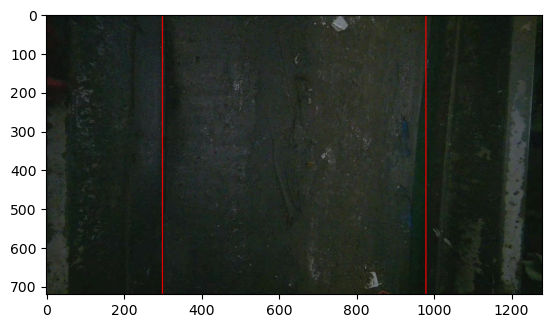

In [19]:

# 이미지 경로
image_path = '../wim_data/objects/conveyer_resized.jpg'

# 영역 정의 (x 시작, y 시작, 너비, 높이)
rectangle = (300, 0, 680, 740)  # 예시 좌표

# 이미지 로드
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 시각화할 사각형 그리기
start_point = (rectangle[0], rectangle[1])
end_point = (rectangle[0] + rectangle[2], rectangle[1] + rectangle[3])
color = (255, 0, 0)  # 빨간색
thickness = 2

image_with_rectangle = cv2.rectangle(image_rgb, start_point, end_point, color, thickness)

# 이미지 시각화
plt.imshow(image_with_rectangle)
plt.show()
